In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
tf.__version__

'2.7.0'


# Only if you have a GPU

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
# only if you want to see how commands are executed
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################


1 Physical GPUs, 1 Logical GPU


# Loading the Data

In [3]:
#!wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

In [4]:
#!unzip gmb-2.2.0.zip

In [5]:
import os

In [6]:
data_root = '../data/gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [7]:
fnames[:2]

['../data/gmb-2.2.0/data/p00\\d0018\\en.tags',
 '../data/gmb-2.2.0/data/p00\\d0025\\en.tags']

In [8]:
!mkdir "../data/ner"

A subdirectory or file ../data/ner already exists.


In [9]:
import csv
import collections
 
ner_tags = collections.Counter()
iob_tags = collections.Counter()

def strip_ner_subcat(tag):
    # NER tags are of form {cat}-{subcat}
    # eg tim-dow. We only want first part
    return tag.split("-")[0]


def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        iob_tags[token] += 1
    return iob_tokens  

total_sentences = 0
outfiles = []
for idx, file in enumerate(fnames):
    with open(file, 'rb') as content:
        data = content.read().decode('utf-8').strip()
        sentences = data.split("\n\n")
        print(idx, file, len(sentences))
        total_sentences += len(sentences)
        
        with open("../data/ner/"+str(idx)+"-"+os.path.basename(file), 'w', encoding="utf-8") as outfile:
            outfiles.append("../data/ner/"+str(idx)+"-"+os.path.basename(file))
            writer = csv.writer(outfile)
            
            for sentence in sentences: 
                toks = sentence.split('\n')
                words, pos, ner = [], [], []
                
                for tok in toks:
                    t = tok.split("\t")
                    words.append(t[0])
                    pos.append(t[1])
                    ner_tags[t[3]] += 1
                    ner.append(strip_ner_subcat(t[3]))
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)])

0 ../data/gmb-2.2.0/data/p00\d0018\en.tags 7
1 ../data/gmb-2.2.0/data/p00\d0025\en.tags 6
2 ../data/gmb-2.2.0/data/p00\d0027\en.tags 5
3 ../data/gmb-2.2.0/data/p00\d0030\en.tags 4
4 ../data/gmb-2.2.0/data/p00\d0044\en.tags 6
5 ../data/gmb-2.2.0/data/p00\d0047\en.tags 6
6 ../data/gmb-2.2.0/data/p00\d0054\en.tags 6
7 ../data/gmb-2.2.0/data/p00\d0059\en.tags 5
8 ../data/gmb-2.2.0/data/p00\d0060\en.tags 6
9 ../data/gmb-2.2.0/data/p00\d0072\en.tags 6
10 ../data/gmb-2.2.0/data/p00\d0086\en.tags 6
11 ../data/gmb-2.2.0/data/p00\d0090\en.tags 16
12 ../data/gmb-2.2.0/data/p00\d0094\en.tags 7
13 ../data/gmb-2.2.0/data/p00\d0100\en.tags 5
14 ../data/gmb-2.2.0/data/p00\d0140\en.tags 7
15 ../data/gmb-2.2.0/data/p00\d0144\en.tags 8
16 ../data/gmb-2.2.0/data/p00\d0154\en.tags 7
17 ../data/gmb-2.2.0/data/p00\d0155\en.tags 6
18 ../data/gmb-2.2.0/data/p00\d0158\en.tags 6
19 ../data/gmb-2.2.0/data/p00\d0160\en.tags 6
20 ../data/gmb-2.2.0/data/p00\d0165\en.tags 7
21 ../data/gmb-2.2.0/data/p00\d0167\en.tags

In [10]:
print("total number of sentences: ", total_sentences)

total number of sentences:  62010


In [11]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'per-mid': 1, 'art-add': 1})
Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62})


In [12]:
import matplotlib.pyplot as plt

labels, values = zip(*iob_tags.items())

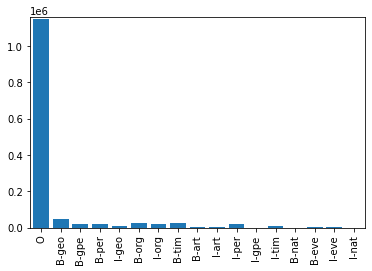

In [13]:
indexes = np.arange(len(labels))


plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Normalizing and Vectorizing

In [14]:
import glob
import pandas as pd

# could use `outfiles` param as well
files = glob.glob("../data/ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, 
                                 names=["text", "label", "pos"]) 
                for f in files], ignore_index = True)

In [15]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [16]:
### Keras tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
text_tok = Tokenizer(filters='[\\]^\t\n', lower=False,
                     split=' ', oov_token='<OOV>')

pos_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

ner_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

In [17]:
text_tok.fit_on_texts(data_pd['text'])
pos_tok.fit_on_texts(data_pd['pos'])
ner_tok.fit_on_texts(data_pd['label'])

In [20]:
ner_config = ner_tok.get_config()
text_config = text_tok.get_config()

In [21]:
print(ner_config)
#print(ner_tok.get_config())

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"O": 1146068, "B-geo": 48876, "B-gpe": 20436, "B-per": 21984, "I-geo": 9512, "B-org": 26195, "I-org": 21899, "B-tim": 26296, "B-art": 503, "I-art": 364, "I-per": 22270, "I-tim": 8493, "B-eve": 391, "I-eve": 318, "I-gpe": 244, "B-nat": 238, "I-nat": 62}', 'word_docs': '{"B-gpe": 16565, "O": 61999, "B-geo": 31660, "B-per": 17499, "I-geo": 7738, "B-org": 20478, "I-org": 11011, "B-tim": 22345, "B-art": 425, "I-art": 207, "I-per": 13805, "I-tim": 5526, "B-eve": 361, "I-eve": 201, "I-gpe": 224, "I-nat": 50, "B-nat": 211}', 'index_docs': '{"9": 16565, "2": 61999, "3": 31660, "7": 17499, "10": 7738, "5": 20478, "8": 11011, "4": 22345, "12": 425, "14": 207, "6": 13805, "11": 5526, "13": 361, "15": 201, "16": 224, "18": 50, "17": 211}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

In [22]:
text_vocab = eval(text_config['index_word'])
ner_vocab = eval(ner_config['index_word'])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 39422
Unique NER tags in vocab: 18


In [23]:
x_tok = text_tok.texts_to_sequences(data_pd['text'])
y_tok = ner_tok.texts_to_sequences(data_pd['label'])

In [24]:
print(text_tok.sequences_to_texts([x_tok[1]]), data_pd['text'][1])
print(ner_tok.sequences_to_texts([y_tok[1]]), data_pd['label'][1])

['Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "'] Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
['O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O'] O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O


In [25]:
# now, pad seqences to a maximum length
from tensorflow.keras.preprocessing import sequence

max_len = 50

x_pad = sequence.pad_sequences(x_tok, padding='post',
                              maxlen=max_len)
y_pad = sequence.pad_sequences(y_tok, padding='post',
                              maxlen=max_len)

In [26]:
print(x_pad.shape, y_pad.shape)

(62010, 50) (62010, 50)


In [27]:
text_tok.sequences_to_texts([x_pad[1]])

['Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [28]:
ner_tok.sequences_to_texts([y_pad[1]])

['O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [29]:
num_classes = len(ner_vocab)+1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(62010, 50, 19)

# Building and Training the BiLSTM Model

In [30]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
dropout=0.5
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(units=rnn_units, 
                           return_sequences=True, 
                           dropout=0.5,  
                           kernel_initializer=tf.keras.initializers.he_normal())),
  #  LSTM(rnn_units, return_sequences=True, 
  #           dropout=0.5, 
  #           recurrent_dropout=0.5),
    TimeDistributed(Dense(num_classes, activation="relu"))
    #tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  
  return model

In [31]:
model = build_model_bilstm(
                        vocab_size = vocab_size,
                        embedding_dim=embedding_dim,
                        rnn_units=rnn_units,
                        batch_size=BATCH_SIZE,
                        classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (90, None, 64)            2523072   
                                                                 
 bidirectional (Bidirectiona  (90, None, 200)          132000    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (90, None, 19)           3819      
 ibuted)                                                         
                                                                 
Total params: 2,658,891
Trainable params: 2,658,891
Non-trainable params: 0
_________________________________________________________________


In [32]:
X = x_pad 

In [33]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = X[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = X[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]

In [34]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49590, 50) (49590, 50, 19)
(12420, 50) (12420, 50, 19)


In [35]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)

Epoch 1/15
551/551 [==============================] - 56s 40ms/step - loss: nan - accuracy: 1.3125e-04 1s - loss: nan 
Epoch 2/15
551/551 [==============================] - 22s 40ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/15
551/551 [==============================] - 23s 41ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/15
551/551 [==============================] - 22s 40ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/15
551/551 [==============================] - 21s 38ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/15
551/551 [==============================] - 24s 43ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/15
551/551 [==============================] - 22s 40ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/15
551/551 [==============================] - 22s 40ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/15
551/551 [==============================] - 22s 41ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/15
551/551 [==============================] - 22

In [36]:
# batch size in eval
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 5s 16ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [37]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

In [38]:
text_tok.sequences_to_texts([X_test[1]])

['Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [39]:
ner_tok.sequences_to_texts([y_pad[1]])

['O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [40]:
y_pred = tf.argmax(y_pred, -1)
y_pred.shape

TensorShape([12420, 50])

In [41]:
y_pnp = y_pred.numpy()

In [42]:
ner_tok.sequences_to_texts([y_pnp[1]])

['<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

## BiLSTM-CRF Model

In [39]:
!pip install tensorflow_addons

In [43]:
import tensorflow_addons as tfa
tfa.__version__

'0.15.0'

In [44]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class CRFLayer(Layer):
  """
  Computes the log likelihood during training
  Performs Viterbi decoding during prediction
  """
  def __init__(self,
               label_size,
               mask_id=0,
               trans_params=None,
               name='crf',
               **kwargs):
    super(CRFLayer, self).__init__(name=name, **kwargs)
    self.label_size = label_size
    self.mask_id = mask_id
    self.transition_params = None
    
    if trans_params is None:  # not reloading pretrained params
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)),
                                         trainable=False)
    else:
        self.transition_params = trans_params

  def get_seq_lengths(self, matrix):
    # matrix is of shape (batch_size, max_seq_len)
    mask = tf.not_equal(matrix, self.mask_id)
    seq_lengths = tf.math.reduce_sum(
                                    tf.cast(mask, dtype=tf.int32), 
                                    axis=-1)
    return seq_lengths

  def call(self, inputs, seq_lengths, training=None):
    if training is None:
        training = K.learning_phase()
    
    # during training, this layer just returns the logits
    if training:
        return inputs
    
    # viterbi decode logic to return proper 
    # results at inference
    _, max_seq_len, _ = inputs.shape
    seqlens = seq_lengths
    paths = []
    for logit, text_len in zip(inputs, seqlens):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], 
                                              self.transition_params)
        paths.append(self.pad_viterbi(viterbi_path, max_seq_len))

    return tf.convert_to_tensor(paths) 
  
  def pad_viterbi(self, viterbi, max_seq_len):
    if len(viterbi) < max_seq_len:
        viterbi = viterbi + [self.mask_id] * (max_seq_len - len(viterbi))
    return viterbi

  def get_proper_labels(self, y_true):
    shape = y_true.shape
    if len(shape) > 2:
        return tf.argmax(y_true, -1, output_type=tf.int32)
    return y_true
        
  def loss(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

    seq_lengths = self.get_seq_lengths(y_true)
    log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, 
                                                                y_true, seq_lengths)

    # save transition params
    self.transition_params = tf.Variable(self.transition_params, trainable=False)
    # calc loss
    loss = - tf.reduce_mean(log_likelihoods)
    return loss


In [45]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras import backend as K

class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size,
                name='BilstmCrfModel', **kwargs):
        super(NerModel, self).__init__(name=name, **kwargs)
        self.num_hidden = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size

        self.embedding = Embedding(vocab_size, embedding_size, 
                                   mask_zero=True, name="embedding")
        self.biLSTM =Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
        self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
        self.crf = CRFLayer(self.label_size, name="crf")

    def call(self, text, labels=None, training=None):
        seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), 
                                               dtype=tf.int32), axis=-1) 
        
        if training is None:
            training = K.learning_phase()

        inputs = self.embedding(text)
        bilstm = self.biLSTM(inputs)
        logits = self.dense(bilstm)
        outputs = self.crf(logits, seq_lengths, training)
        
        return outputs

In [46]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [47]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = x_pad[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = x_pad[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]
Y_train_int = tf.cast(Y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [48]:
loss_metric = tf.keras.metrics.Mean()

epochs = 5

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (text_batch, labels_batch) in enumerate(train_dataset):
        labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
        with tf.GradientTape() as tape:
            logits = blc_model(text_batch, training=True)
            loss = blc_model.crf.loss(labels_max, logits)

            grads = tape.gradient(loss, blc_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))
            
            loss_metric(loss)
        if step % 50 == 0:
          print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(68.373436, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(31.673256, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(24.338514, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.960438, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(18.423616, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(16.56354, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(15.160471, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(14.047768, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(13.165917, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(12.364613, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(11.652219, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(11.019144, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(11.006461, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(10.439715, shape=(), dtype=float32)
step 100: mean loss =

In [49]:
Y_test_int = tf.cast(Y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [50]:
out = blc_model.predict(test_dataset.take(1))

In [51]:
# check the outputs
print(out[1], tf.argmax(Y_test[1], -1))
print(out[2], tf.argmax(Y_test[2], -1))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 6 2 8 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
[ 2  2  2  2  2  2  5  2  2  2  2  4 10  2  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0] tf.Tensor(
[ 2  2  2  2  2  2  2  2  2  2  2  3 10  2  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(50,), dtype=int64)


In [52]:
text_tok.sequences_to_texts([X_test[2]])

['They marched from the Houses of Parliament to a rally in Hyde Park . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [53]:
print("Ground Truth: ", ner_tok.sequences_to_texts([tf.argmax(Y_test[2], -1).numpy()]))
print("Prediction: ", ner_tok.sequences_to_texts([out[2]]))

Ground Truth:  ['O O O O O O O O O O O B-geo I-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Prediction:  ['O O O O O O B-org O O O O B-tim I-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [54]:
print(ner_tok.sequences_to_texts([tf.argmax(Y_test[1], -1).numpy()]))
print(ner_tok.sequences_to_texts([out[1]]))

['O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
['O O O O O O O O O O O O O O O O O O B-per I-per O I-org O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [55]:
blc_model.summary()

Model: "BilstmCrfModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2523072   
                                                                 
 bilstm (Bidirectional)      multiple                  132000    
                                                                 
 dense (TimeDistributed)     multiple                  3819      
                                                                 
 crf (CRFLayer)              multiple                  361       
                                                                 
Total params: 2,659,252
Trainable params: 2,658,891
Non-trainable params: 361
_________________________________________________________________


In [56]:
def np_precision(pred, true):
    # expect numpy arrays
    assert pred.shape == true.shape
    assert len(pred.shape) == 2
    mask_pred = np.ma.masked_equal(pred, 0)
    mask_true = np.ma.masked_equal(true, 0)
    acc = np.equal(mask_pred, mask_true)
    return np.mean(acc.compressed().astype(int))

In [57]:
np_precision(out, tf.argmax(Y_test[:BATCH_SIZE], -1).numpy())

0.9542981501632208